Import necessary modules

In [1]:
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pyDOE import lhs

Create data for learing

In [2]:
if torch.cuda.is_available():
    device = torch.device ("cuda")
else:
    device = torch.device ("cpu")

viscosity = 0.01
epochs = 100000
torch.set_default_dtype(torch.float64)


print (f"Default devise: {device}")

def lhs_create ():

    x_colloc = torch.tensor (lhs(1, 10000)).requires_grad_ (True).to(device)
    t_colloc = torch.tensor (lhs(1, 10000)).requires_grad_ (True).to(device)

    x_boundary = torch.cat([torch.zeros(5000, 1), torch.ones(5000, 1)], dim=0).requires_grad_ (True).to(device)
    t_boundary = torch.tensor(lhs (1, 10000)).requires_grad_ (True).to(device)

    x_initial = torch.tensor(lhs (1, 10000)).requires_grad_ (True).to(device)
    t_initial = torch.zeros(10000, 1).to(device)

    return x_colloc, t_colloc, x_boundary, t_boundary, x_initial, t_initial

def create_data_random ():

    x_colloc = torch.rand(10000, 1, requires_grad=True).to(device)
    t_colloc = torch.rand(10000, 1, requires_grad=True).to(device)

    x_boundary = torch.cat([torch.zeros(5000, 1), torch.ones(5000, 1)], dim=0).to(device)
    t_boundary = torch.rand(10000, 1).to(device)

    x_initial = torch.rand(10000, 1).to(device)
    t_initial = torch.zeros(10000, 1).to(device)

    return x_colloc, t_colloc, x_boundary, t_boundary, x_initial, t_initial

def discrete ():
    x_colloc = torch.tensor (torch.linspace (0, 1, 100)).requires_grad_(True).to(device)
    t_colloc = torch.tensor (torch.linspace (0, 1, 100)).requires_grad_(True).to(device)

    x_rod_test = (np.repeat (x_colloc.cpu().detach().numpy(), t_colloc.shape, axis = 0)).reshape (-1, 1)
    t_test = (np.tile (t_colloc.cpu().detach().numpy(), t_colloc.shape)).reshape (-1, 1)
    xt_test = np.hstack ((x_rod_test, t_test))
    x_colloc, t_colloc = torch.tensor (xt_test[:, 0]).requires_grad_(True).to(device), torch.tensor (xt_test[:, 1]).requires_grad_(True).to(device)


    x_boundary = torch.cat([torch.zeros(5000, 1), torch.ones(5000, 1)], dim=0).requires_grad_(True).to(device)
    t_boundary = torch.tensor (torch.linspace (0, 1, 5000)).requires_grad_(True).to(device)
    t_boundary_temp = torch.tensor (np.tile (t_boundary.cpu().detach().numpy(), 2)).requires_grad_(True).to(device)
    

    x_initial = torch.tensor (torch.linspace (0, 1, 10000)).requires_grad_(True).to(device)
    t_initial = torch.zeros(10000, 1).to(device)

    return x_colloc, t_colloc, x_boundary, t_boundary_temp, x_initial, t_initial


x_rod, t_rod, x_bd, t_bd, x_init, t_init = create_data_random ()


Default devise: cuda


Check education points

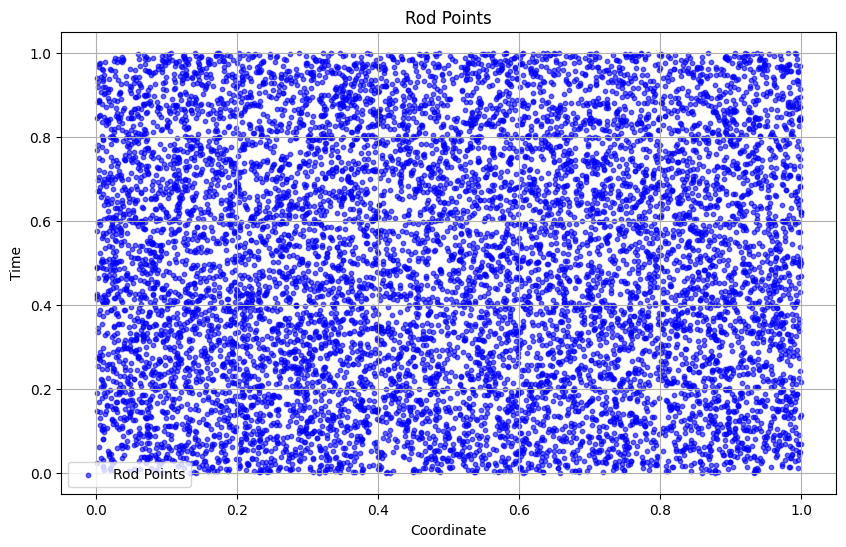

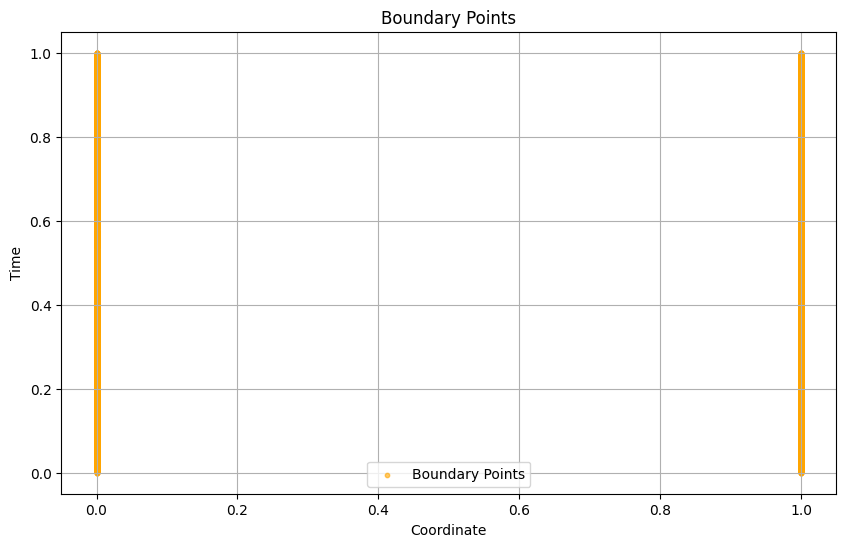

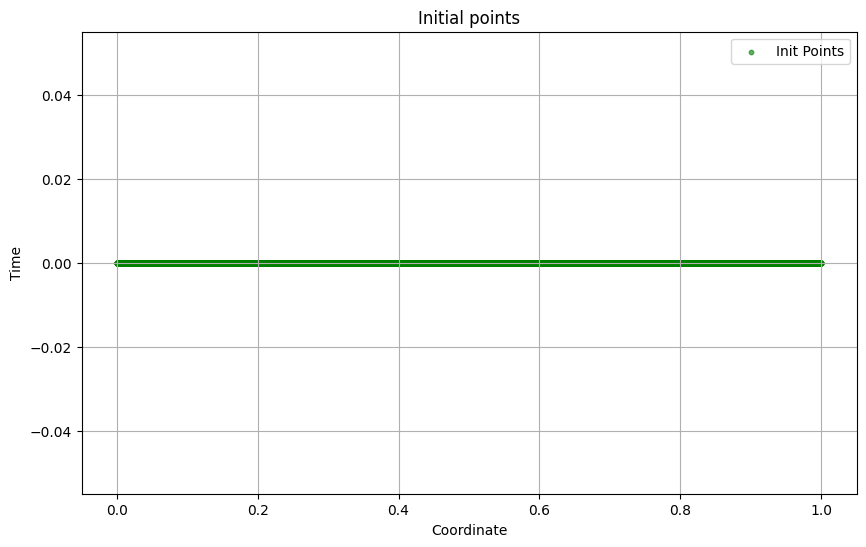

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(x_rod.cpu().detach().numpy(), t_rod.cpu().detach().numpy(), c='blue', s=10, alpha=0.6, label='Rod Points')
plt.title("Rod Points")
plt.xlabel("Coordinate")
plt.ylabel("Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(x_bd.cpu().detach().numpy(), t_bd.cpu().detach().numpy(), c='orange', s=10, alpha=0.6, label='Boundary Points')
plt.title(f"Boundary Points")
plt.xlabel("Coordinate")
plt.ylabel("Time")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(x_init.cpu().detach().numpy(), t_init.cpu().detach().numpy(), c='green', s=10, alpha=0.6, label='Init Points')
plt.title(f"Initial points")
plt.xlabel("Coordinate")
plt.ylabel("Time")
plt.grid(True)
plt.legend()
plt.show()

Initializate model

In [4]:
def init_weight(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

In [5]:
class PINN (nn.Module):
    def __init__ (self, n_hidden, n_neurons, activation, verbose = True):
        super().__init__ ()
        self.model = nn.Sequential ()
        self.build_NN (n_hidden, n_neurons, activation)
        self.model.to(device)


        if verbose:
            print (self.model)

        self.model.apply (init_weight)


    def build_NN (self,n_hidden, n_neurons, activation):
        self.model.add_module ('input layer',nn.Linear (2, n_neurons))
        self.model.add_module ('activation func', activation)
        
        for _ in range (n_hidden-1):
            self.model.add_module (f'hidden layer number: {_}', nn.Linear (n_neurons, n_neurons))
            self.model.add_module (f'activation func {_}', activation)

        self.model.add_module ('Output layer',nn.Linear (n_neurons, 1))

    def forward (self, x, t):
        x = torch.concat ([x,t], dim=1).to(device)
        out = self.model (x)
        return out
    

def pde_loss(model, x, t):
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, create_graph=True, grad_outputs=torch.ones_like(t_rod))[0]
    u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(x_rod))[0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(x_rod))[0]
    
    physics_loss = u_t + u * u_x - viscosity * u_xx 
    physics_loss = torch.mean(physics_loss**2)
    return physics_loss

def boundary_loss(model, x, t):

    u = model(x, t)
    loss = torch.mean(torch.square(u))
    return loss

def initial_loss(model, x, t):

    u = model(x, t)
    correct_vals = torch.sin(math.pi * x)
    loss = torch.mean((correct_vals - u)**2)
    return loss

Training model

In [6]:
model = PINN(5, 25, nn.Tanh())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
total_loss_graph = []

for epoch in range(epochs):
    optimizer.zero_grad()
    eq_loss = pde_loss(model, x_rod, t_rod)
    bc_loss = boundary_loss(model, x_bd, t_bd)
    init_loss = initial_loss(model, x_init, t_init)

    total_loss = eq_loss + bc_loss + init_loss
    total_loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(f"epoch: {epoch}, loss: {total_loss.item()}")
        total_loss_graph.append (total_loss.item())

model_save_path = f"model_random_0_01.pth"
torch.save(model.state_dict(), model_save_path)
with open("model_random_0_01.txt", 'w') as file: 
    for elem in total_loss_graph:
        file.write(f"{elem}\n")

Sequential(
  (input layer): Linear(in_features=2, out_features=25, bias=True)
  (activation func): Tanh()
  (hidden layer number: 0): Linear(in_features=25, out_features=25, bias=True)
  (activation func 0): Tanh()
  (hidden layer number: 1): Linear(in_features=25, out_features=25, bias=True)
  (activation func 1): Tanh()
  (hidden layer number: 2): Linear(in_features=25, out_features=25, bias=True)
  (activation func 2): Tanh()
  (hidden layer number: 3): Linear(in_features=25, out_features=25, bias=True)
  (activation func 3): Tanh()
  (Output layer): Linear(in_features=25, out_features=1, bias=True)
)


C:\Users\Артем\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch: 0, loss: 0.3437717070196637
epoch: 100, loss: 0.31714253512121543
epoch: 200, loss: 0.29884533459948986
epoch: 300, loss: 0.2829871574047737
epoch: 400, loss: 0.2693300447756355
epoch: 500, loss: 0.25787032622659595
epoch: 600, loss: 0.24854459336097398
epoch: 700, loss: 0.24107882520335921
epoch: 800, loss: 0.2349844519250905
epoch: 900, loss: 0.22968462950031887
epoch: 1000, loss: 0.22467675242363386
epoch: 1100, loss: 0.21962560753297203
epoch: 1200, loss: 0.2143597229839171
epoch: 1300, loss: 0.20882093613545932
epoch: 1400, loss: 0.20301839089719642
epoch: 1500, loss: 0.19700184903120174
epoch: 1600, loss: 0.19084824339436024
epoch: 1700, loss: 0.18465330506519217
epoch: 1800, loss: 0.17852441069613426
epoch: 1900, loss: 0.17257334433595714
epoch: 2000, loss: 0.16690830836987508
epoch: 2100, loss: 0.16162501472824028
epoch: 2200, loss: 0.15679714874086337
epoch: 2300, loss: 0.1524672471665095
epoch: 2400, loss: 0.14864012294008896
epoch: 2500, loss: 0.14528163132390048
epoc

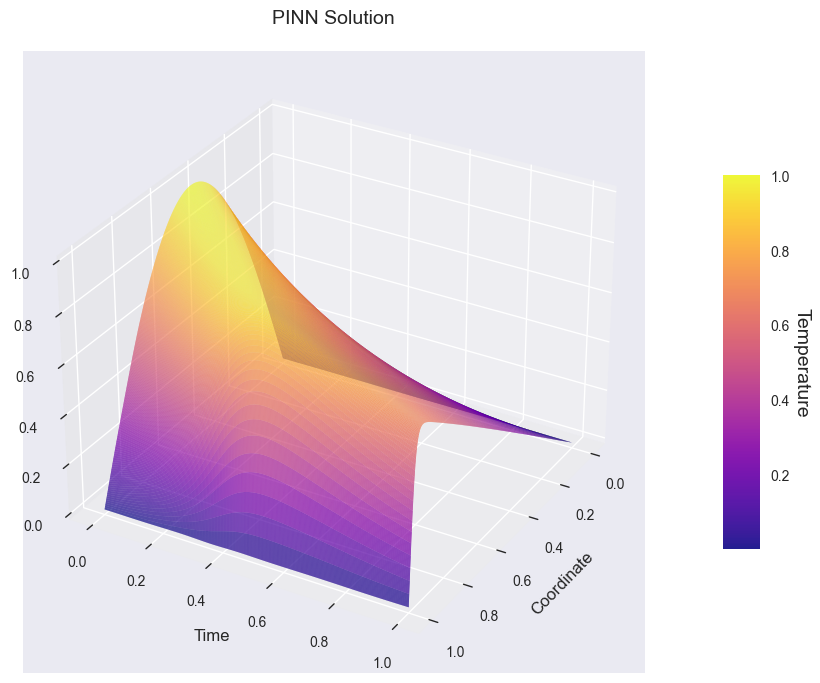

In [ ]:
x_plot = torch.linspace(0, 1, 500).view(-1, 1)
t_plot = torch.linspace(0, 1, 500).view(-1, 1)
X_plot, T_plot = torch.meshgrid(x_plot.view(-1), t_plot.view(-1))

x_flat = X_plot.flatten().view(-1, 1)
t_flat = T_plot.flatten().view(-1, 1)

u_pred = model(x_flat, t_flat).cpu().detach().numpy()
U_plot = u_pred.reshape(500, 500)

fig = plt.figure(figsize=(16, 7), facecolor='white')  

ax1 = fig.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(X_plot.numpy(), T_plot.numpy(), U_plot, 
                        cmap='plasma',  
                        edgecolor='none', 
                        antialiased=True,
                        rstride=1, cstride=1,  
                        alpha=0.9)


ax1.set_xlabel('Coordinate', fontsize=12, labelpad=10)
ax1.set_ylabel('Time', fontsize=12, labelpad=10)
ax1.set_zlabel('u(x,t)', fontsize=12, labelpad=10)
ax1.set_title('PINN Solution', fontsize=14, pad=20)

ax1.grid(True, linestyle=':', alpha=0.5)
ax1.view_init(elev=30, azim=30)

cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10)
cbar1.set_label('Temperature', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


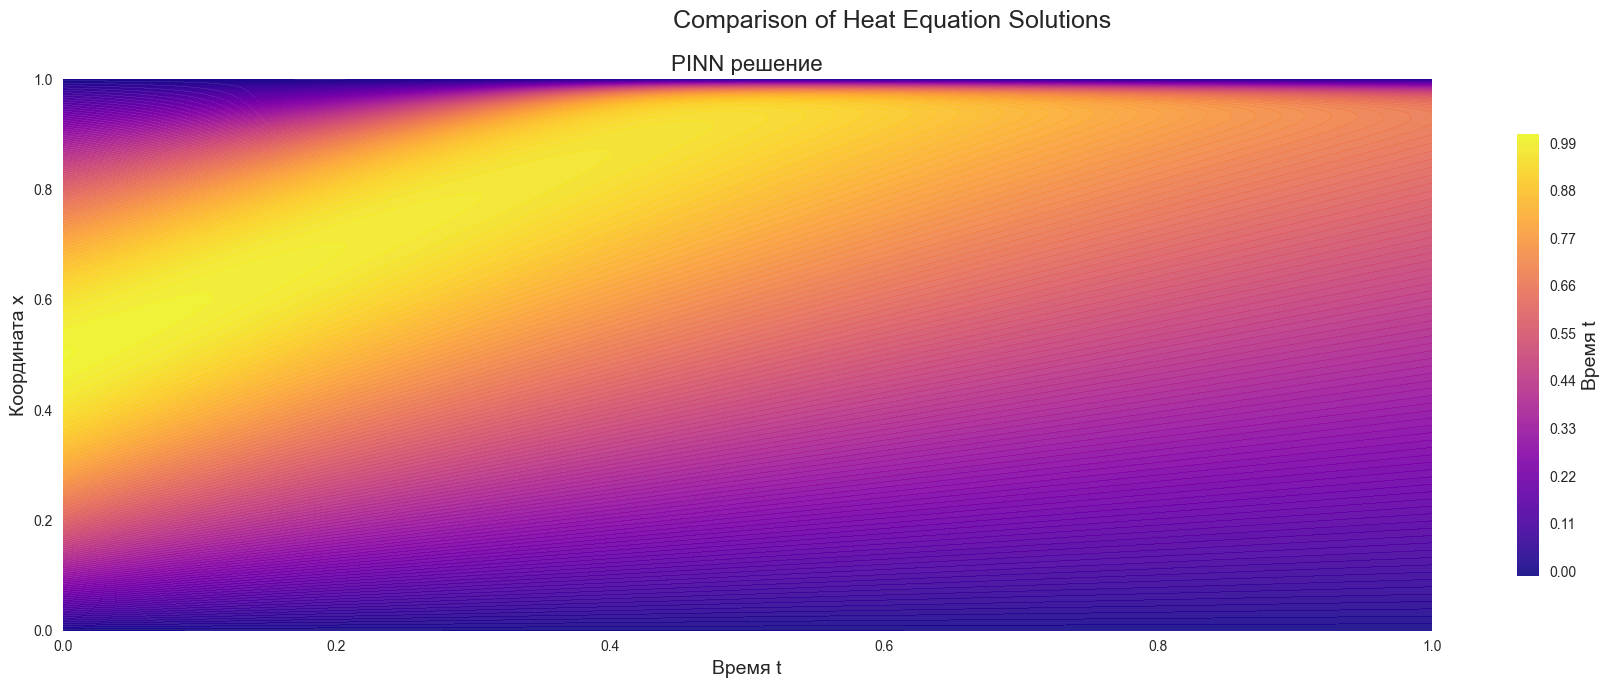

In [ ]:

x_plot_1d = x_plot.flatten().numpy() 
t_plot_1d = t_plot.flatten().numpy()  
U_plot_2d = U_plot.T  


plt.style.use('seaborn-v0_8')  
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

fig, ax1 = plt.subplots(figsize=(18, 7))


contour1 = ax1.contourf(
    t_plot_1d, 
    x_plot_1d, 
    U_plot_2d.T, 
    levels=100, 
    cmap='plasma', 
    alpha=0.9
)
fig.colorbar(contour1, ax=ax1, label='Время t', shrink=0.8)
ax1.set_title('PINN решение')
ax1.set_xlabel('Время t')
ax1.set_ylabel('Координата x')
ax1.set_ylim(0, 1)
ax1.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
from scipy.interpolate import griddata
import seaborn as sns
import pandas as pd
import io

x_plot = torch.linspace(0, 1, 500).view(-1, 1)
t_plot = torch.linspace(0, 1, 500).view(-1, 1)

def create_graph(x_array, temp_value_for_graph):
    plt.clf()
    
    
    x_data = x_array.cpu().detach().squeeze().numpy()
    y_data = temp_value_for_graph.cpu().detach().squeeze().numpy()
    
    
    sns.lineplot(x=x_data, y=y_data)
    
    plt.title(f"PINN нейронная сеть ")
    
    plt.xlabel("Координата x")
    plt.ylabel("Скорость u(x,t)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    

def create_gif (x_array, time_array):
    frames = []
    x_array, time_array = x_array.reshape(-1, 1), time_array.reshape(-1, 1)
    for time in time_array:
        
        time = torch.full_like (x_array,  time.item())

        temp_value_for_graph = model (x_array, time)
        create_graph (x_array,temp_value_for_graph)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(Image.open(buf))
    frames[0].save(f'solution_random_0_01.gif',
              save_all=True,
              append_images=frames[1:],
              duration=30,
              loop=0)
    
create_gif (x_plot, t_plot)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


: 